<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>2.4 d-separation</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import statsmodels.formula.api as smf
from itertools import combinations

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

autopep8   1.5
matplotlib 3.1.3
json       2.0.9
watermark  2.0.2
numpy      1.18.1
pandas     1.0.1
Sun Sep 13 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : b7e1acd9fcd43d710e34c26c6375c4bc440268e9


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Review

In [4]:
fig25 = CausalModel()
fig25.load_model('dags/Primer.Fig.2.5.dot')

In [5]:
fig25.dag.nodes

NodeView(('X', 'R', 'S', 'T', 'U', 'V', 'Y'))

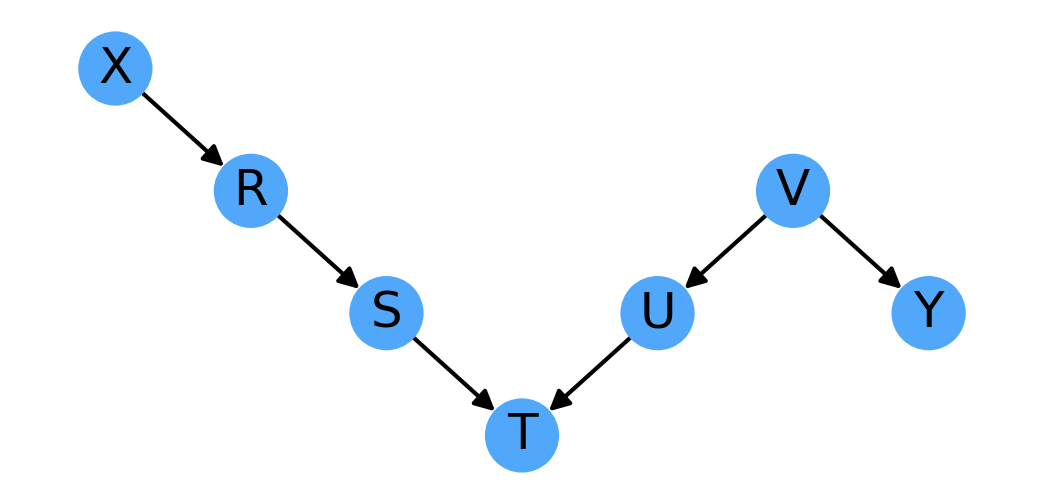

In [6]:
fig, ax = plt.subplots(1, figsize=(4, 2.2))
fig25.pos = {'X': (0, 0), 'R': (1, -1), 'S':(2, -2), 'T':(3, -3), 'U':(4, -2), 'V':(5, -1), 'Y': (6, -2)}
fig25.plot(ax=ax)

In [7]:
nodes = fig25.dag.nodes()

In [8]:
all_pairs = pd.DataFrame(combinations(nodes, 2), columns=['source', 'target'])

In [9]:
all_pairs

,source,target
0,X,R
1,X,S
2,X,T
3,X,U
4,X,V
5,X,Y
6,R,S
7,R,T
8,R,U
9,R,V


In [10]:
all_pairs['candidate'] = True
all_pairs['candidate'] = all_pairs.apply(lambda x: False if len(set(x[:2].values) & {'R', 'V'}) > 0 else x['candidate'], axis=1)

In [11]:
all_pairs = all_pairs[all_pairs['candidate']][['source', 'target']].copy()

In [12]:
all_pairs['Result'] = [
    "Rule 1, Independent",
    "Rule 1, Independent",
    "Blocked, Independent",
    "Blocked, Independent",
    "Rule 0, Dependent",
    "Rule 3, Independent",
    "Blocked, Independent",
    "Rule 0, Dependent",
    "Rule 2, Independent",
    "Rule 2, Independent"
]

### Model Simulation

In [13]:
N = 100000
df = pd.DataFrame({'X': np.random.normal(0, 1, N)})
df['R'] = df['X'] + np.random.normal(0, .1, N)
df['S'] = df['R'] + np.random.normal(0, .1, N)
df['V'] = np.random.normal(0, 1, N)
df['Y'] = df['V'] + np.random.normal(0, .1, N)
df['U'] = df['V'] + np.random.normal(0, .1, N)
df['T'] = np.sqrt(0.5)*df['S'] + np.sqrt(0.5)*df['U'] + np.random.normal(0, .1, N)

In [14]:
remove = set(['R', 'V'])

formula = '%s ~ 1 + %s +' + ' + '.join(remove)

summary = {}

for node_i, node_j in all_pairs[['source', 'target']].values: #combinations(nodes, 2):    
    if len(set([node_i, node_j]) & remove) > 0:
        continue
    
    print(node_i, node_j)
    fml = formula % (node_i, node_j)
    
    results = smf.ols(fml, df).fit()
    summary[(node_i, node_j)] = list(results.conf_int().loc[node_j].values)
    summary[(node_i, node_j)].append(results.params[node_j])
    summary[(node_i, node_j)].append(results.pvalues[node_j])

X S
X T
X U
X Y
S T
S U
S Y
T U
T Y
U Y


### Visualize the coefficients for each pair of variables

In [15]:
summary = pd.DataFrame(summary).T

In [16]:
def plot_coefficients(summary):
    fig, ax = plt.subplots(1)
    ax.axvline(x=0, c='darkgray', linestyle=':', linewidth=2)
    ax.hlines(y=np.arange(summary.shape[0]), xmin=summary[0], xmax=summary[1], lw=2, color=colors[1])
    ax.vlines(ymin=np.arange(summary.shape[0])-.2, ymax=np.arange(summary.shape[0])+.2, x=summary[2], lw=2, color=colors[1])
    ax.set_yticks(np.arange(summary.shape[0]))
    ax.set_yticklabels([r'$r_{%s%s}$' % (node_i, node_j) for node_i, node_j in summary.index])
    ax.set_xlabel('Coeffient estimate')
    ax.set_ylabel('Variable Pair Coefficient')
    ax.grid(linewidth=.5)

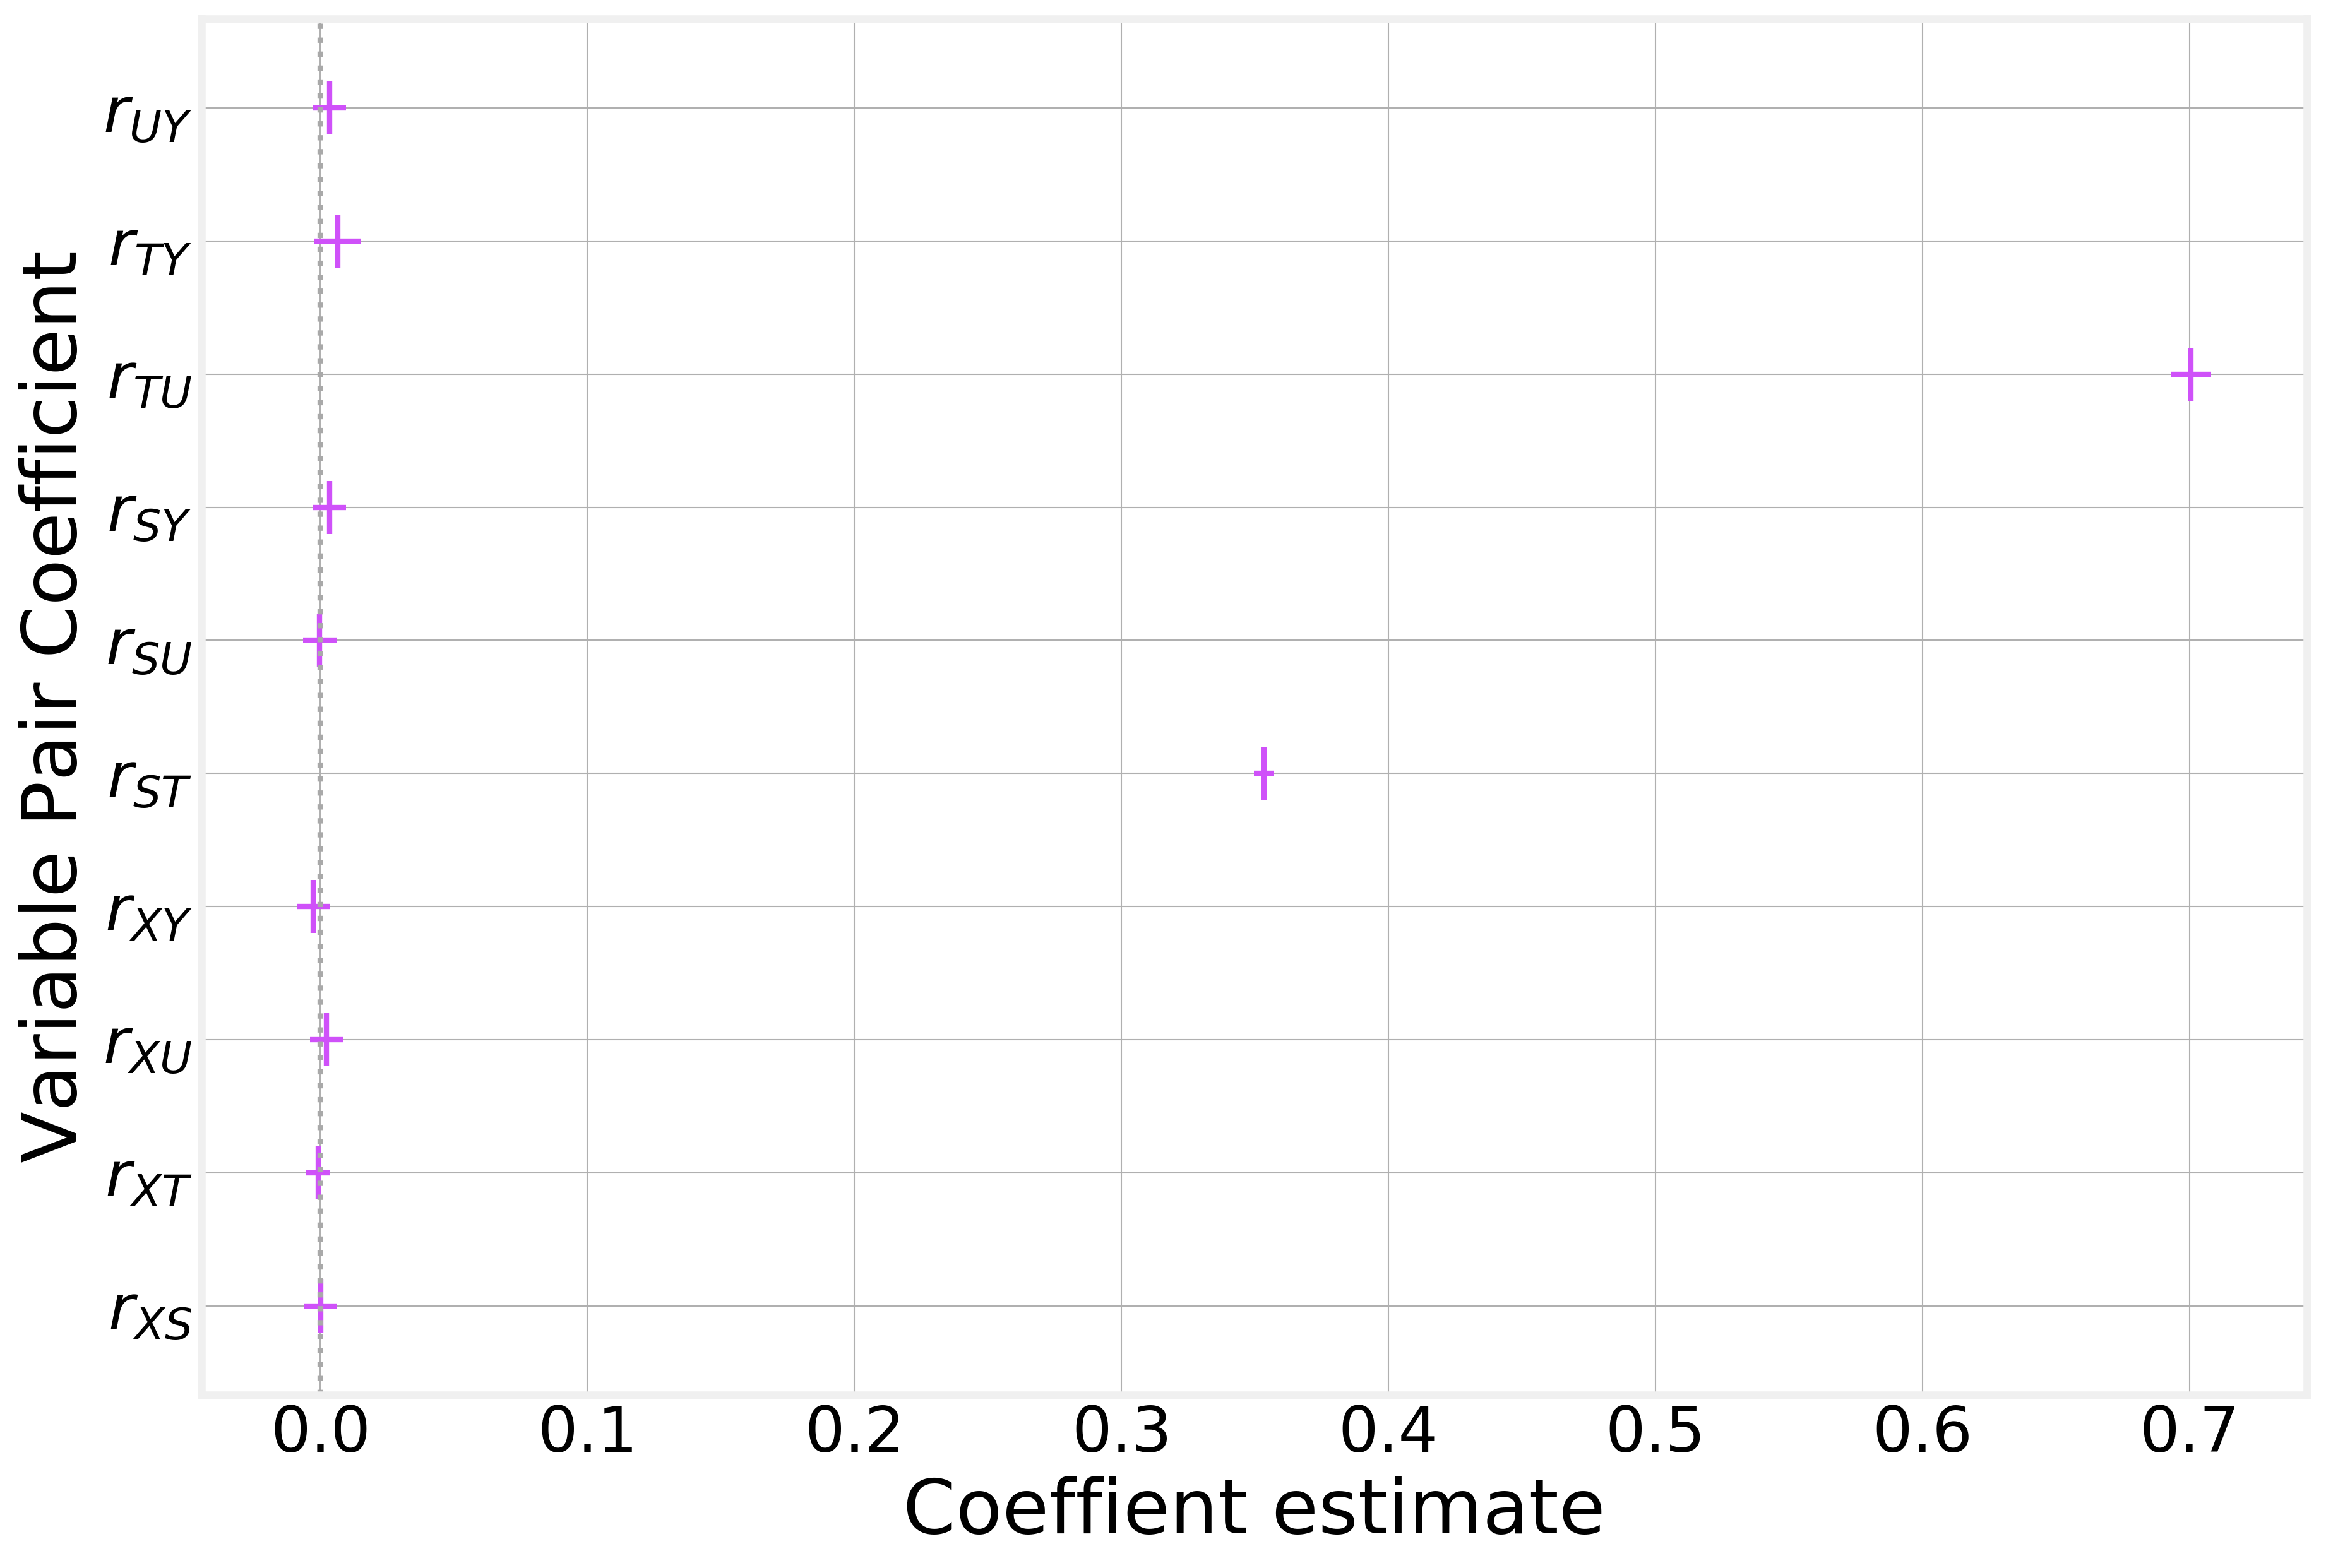

In [17]:
plot_coefficients(summary)

## d-separation

In [18]:
G = CausalModel()
G.add_causation('Uz', 'Z')
G.add_causation('Uw', 'W')
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uu', 'U')
G.add_causation('Z', 'W')
G.add_causation('X', 'W')
G.add_causation('X', 'Y')
G.add_causation('W', 'U')

G.pos = {'Uz':(-1, 1.5), 'Z':(-1, 1), 'W':(0, 0), 'Uw': (0, 0.5), 
         'X': (1, 1), 'Ux':(1, 1.5), 'Y':(2, 1), 'Uy':(2, 1.5),
         'U': (0, -1), 'Uu':(-0.5, -0.5)}

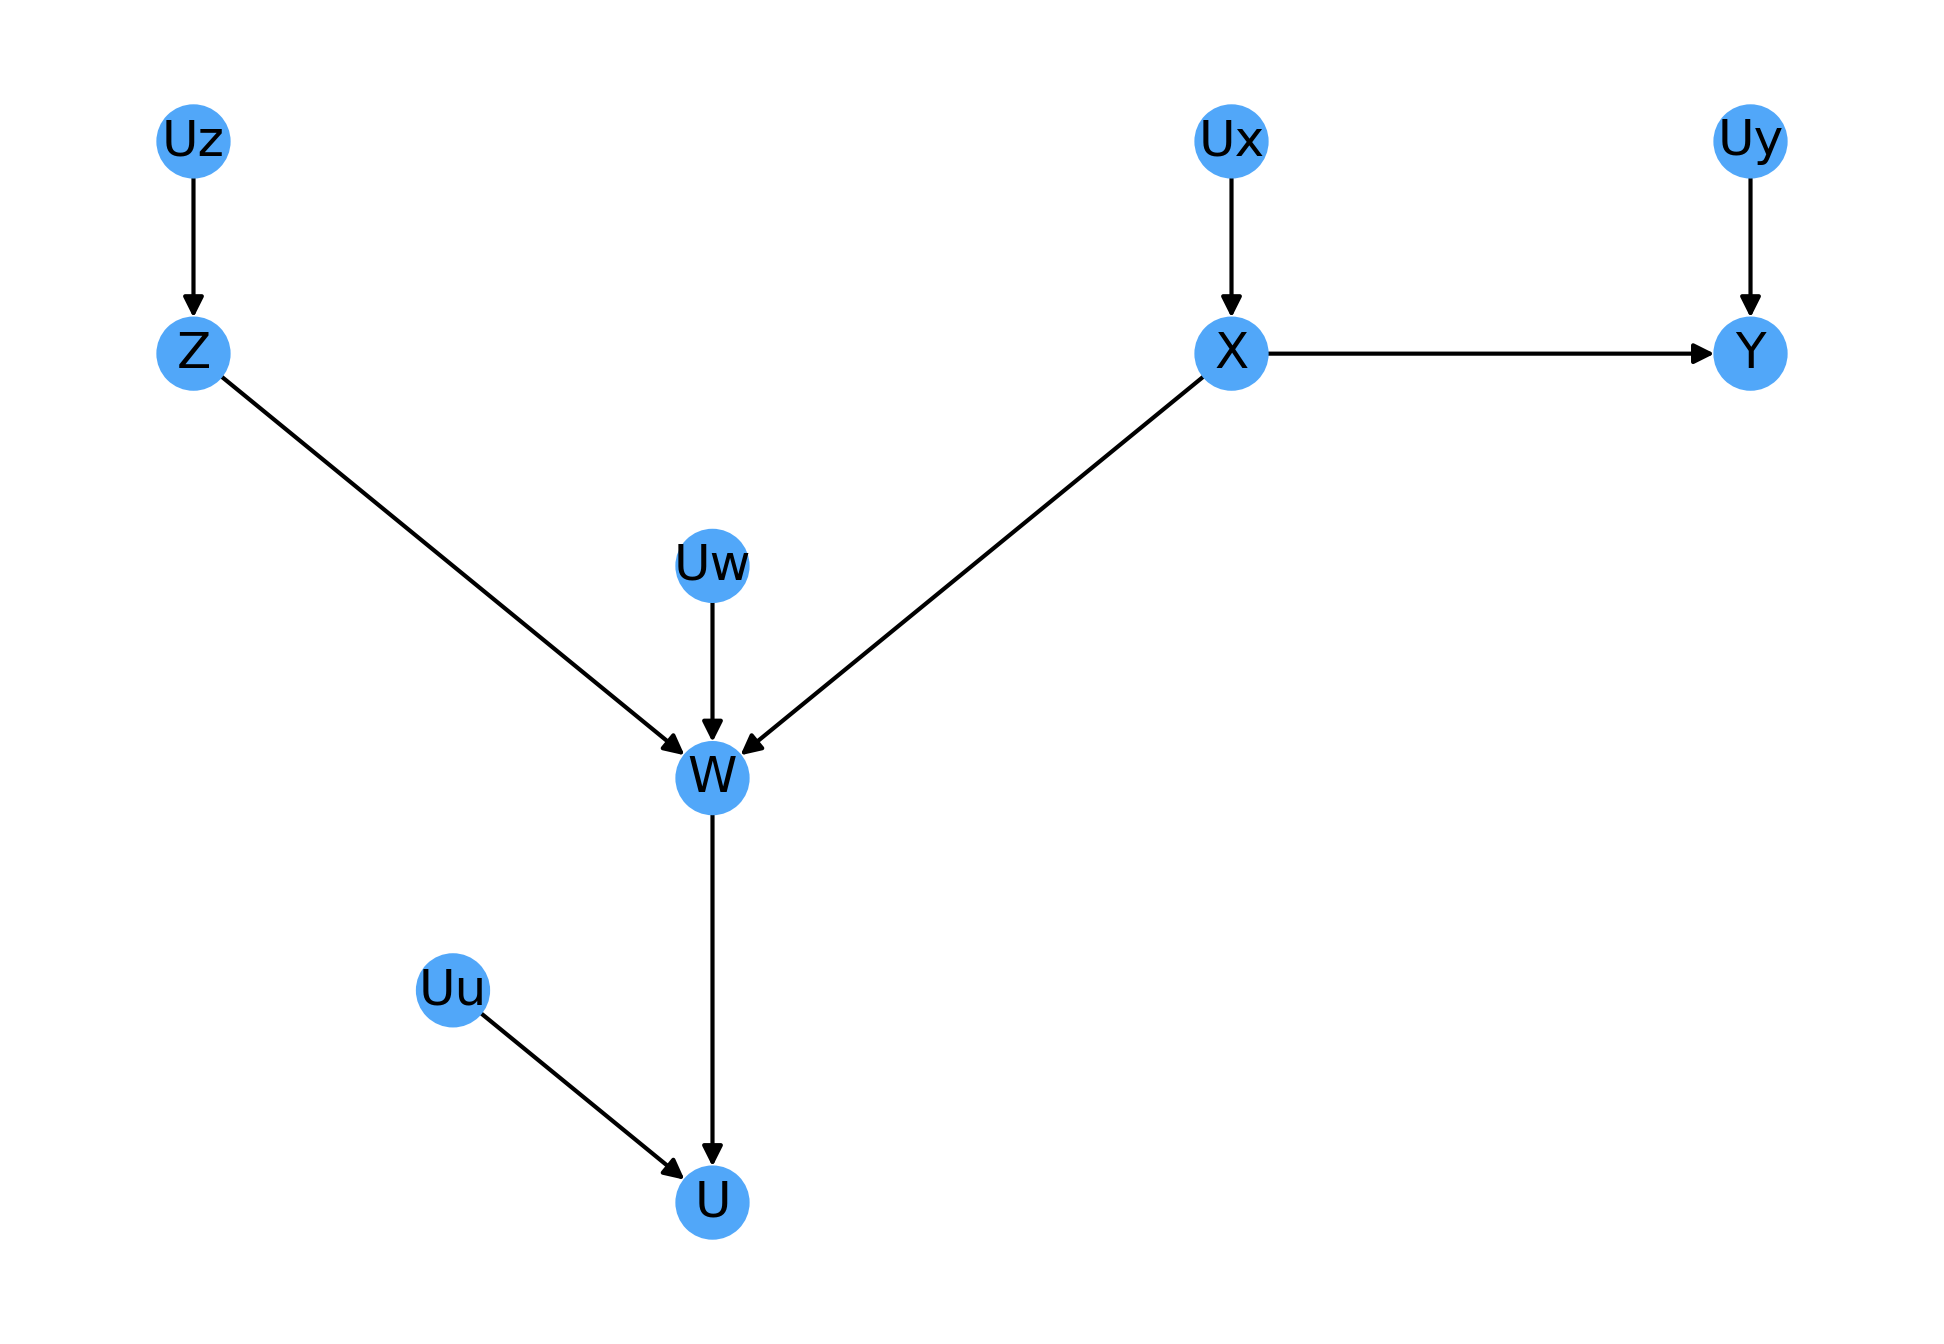

In [19]:
fig, ax = plt.subplots(1, figsize=(7, 5))
G.plot(ax=ax)

In [20]:
G.save_model('dags/Primer.Fig.2.7.dot')

This graph has only one path connecting X and Y

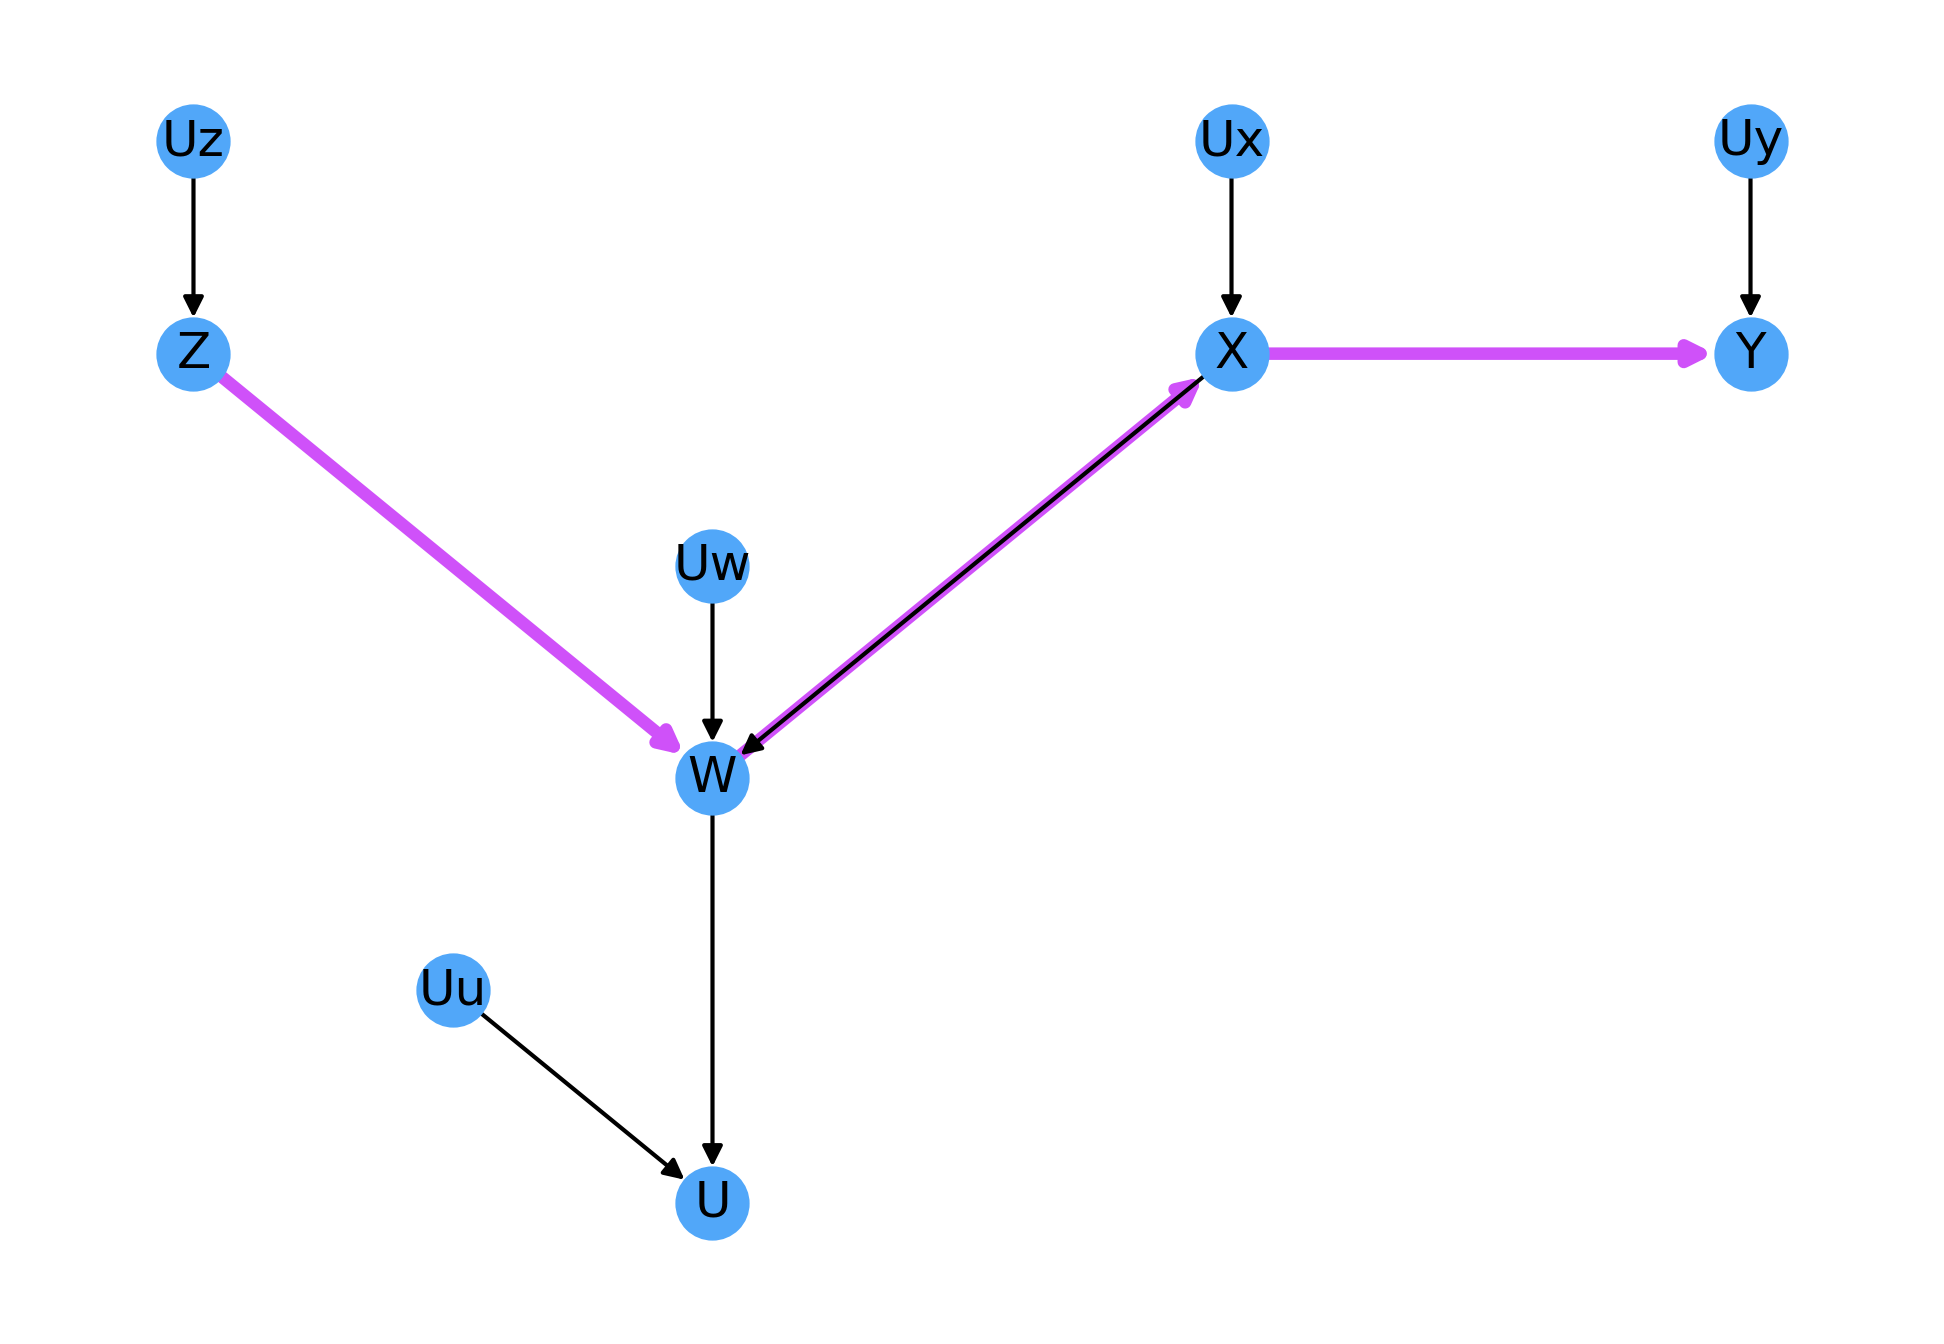

In [21]:
fig, ax_lst = plt.subplots(1, figsize=(7, 5))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(list(G.all_paths('Z', 'Y'))):
    G.plot_path(path, ax=ax_lst[i])

fig.tight_layout()

If we add a second path between X and Y, we obtain:

In [22]:
G = CausalModel()
G.add_causation('Uz', 'Z')
G.add_causation('Uw', 'W')
G.add_causation('Ux', 'X')
G.add_causation('Uy', 'Y')
G.add_causation('Uu', 'U')
G.add_causation('Ut', 'T')
G.add_causation('Z', 'W')
G.add_causation('X', 'W')
G.add_causation('X', 'Y')
G.add_causation('W', 'U')
G.add_causation('T', 'Z')
G.add_causation('T', 'Y')

G.pos = {'Uz':(-1, 1.5), 'Z':(-1, 1), 'W':(0, 0), 'Uw': (0, 0.5), 
         'X': (1, 1), 'Ux':(1, 1.5), 'Y':(2, 1), 'Uy':(2, 1.5),
         'U': (0, -1), 'Uu':(-0.5, -0.5), 'T':(.5, 2), 'Ut':(.5, 2.5)}

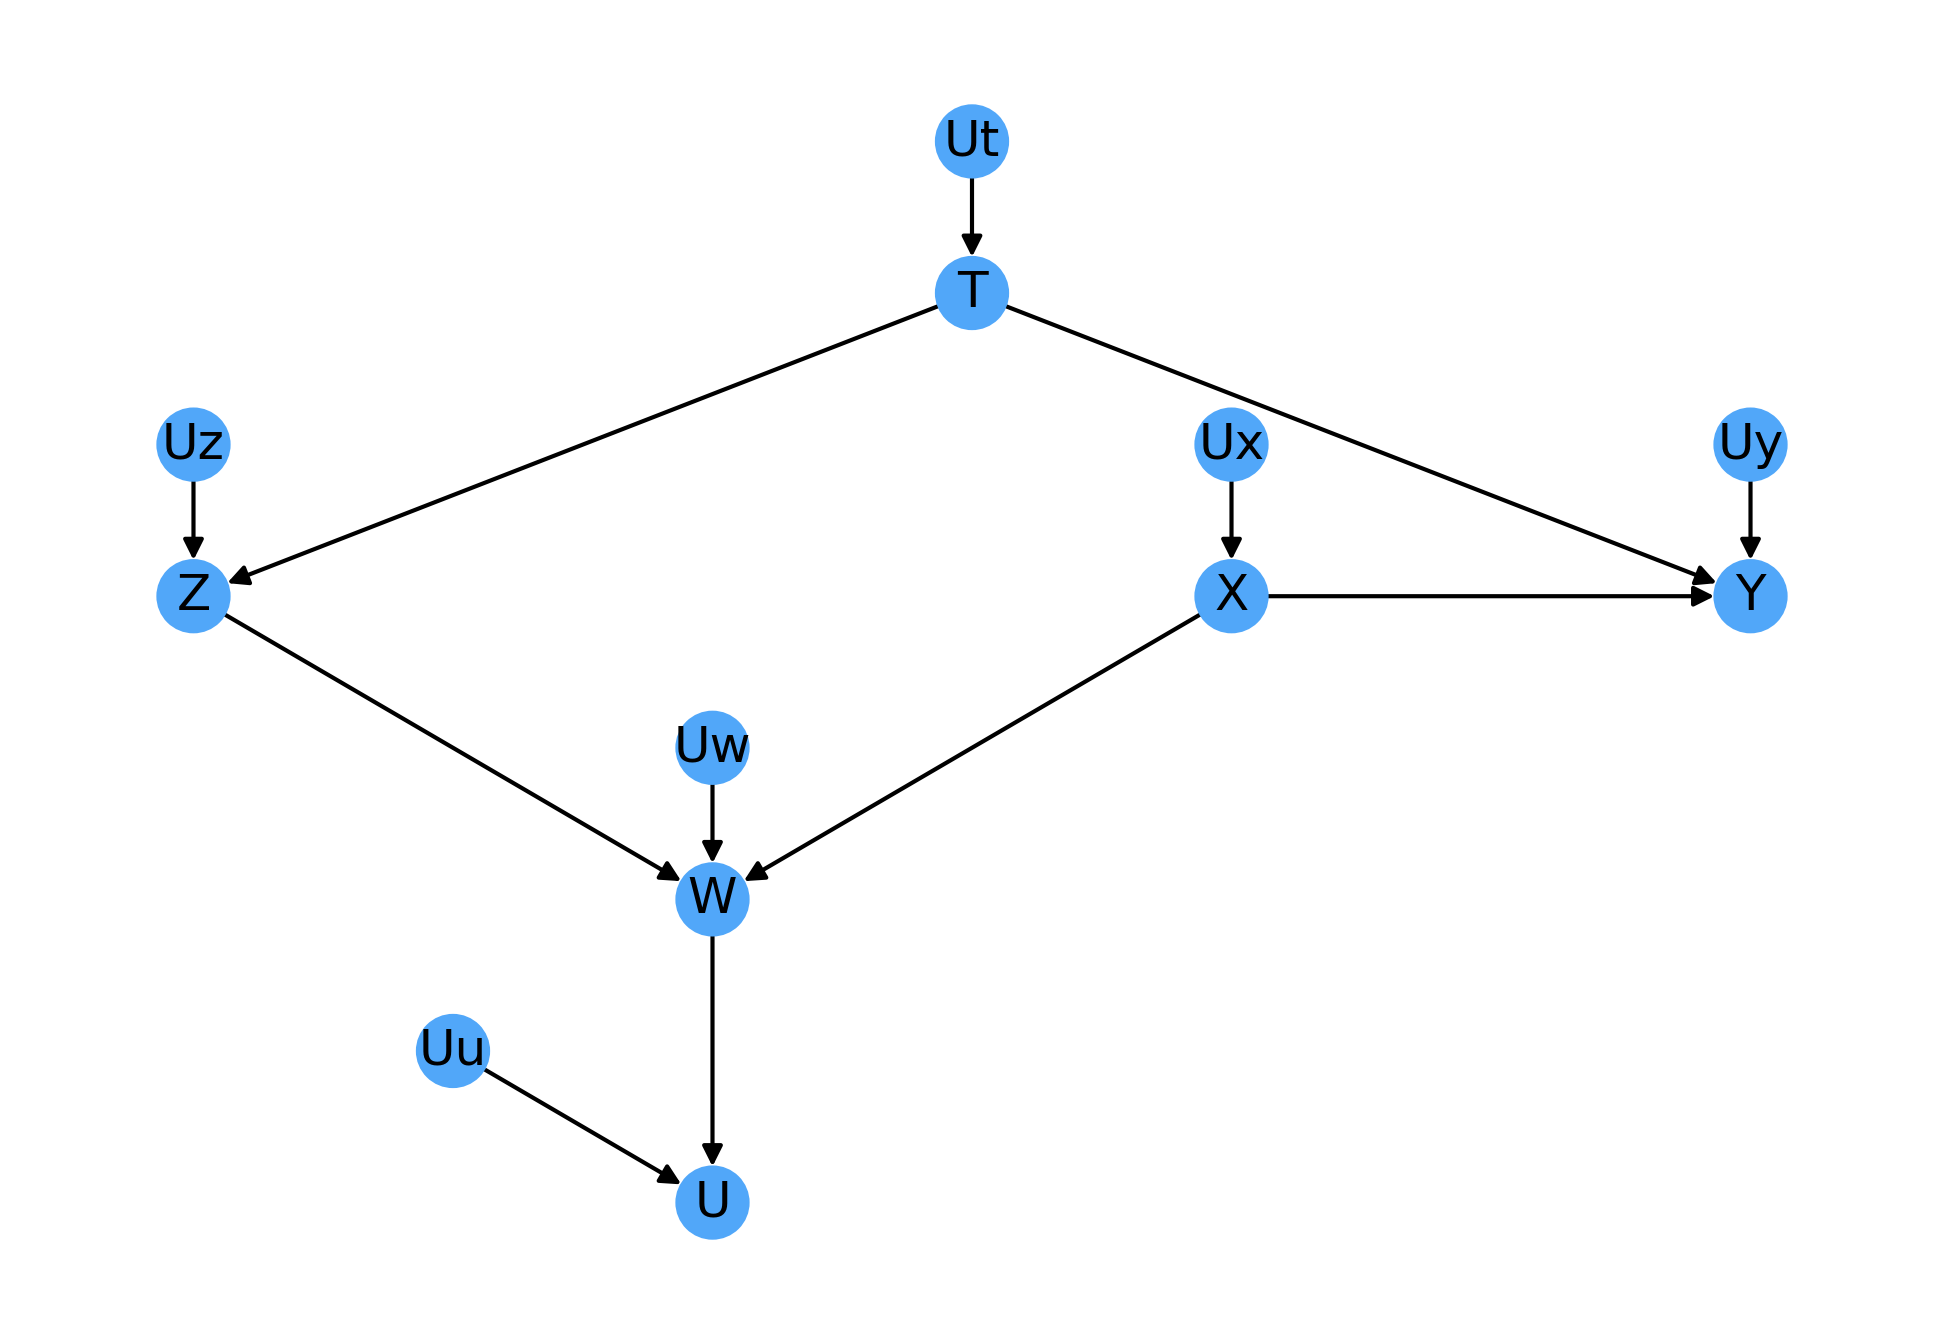

In [23]:
fig, ax = plt.subplots(1, figsize=(7, 5))
G.plot(ax=ax)

In [24]:
G.save_model('dags/Primer.Fig.2.8.dot')

And we can easily visualize both paths

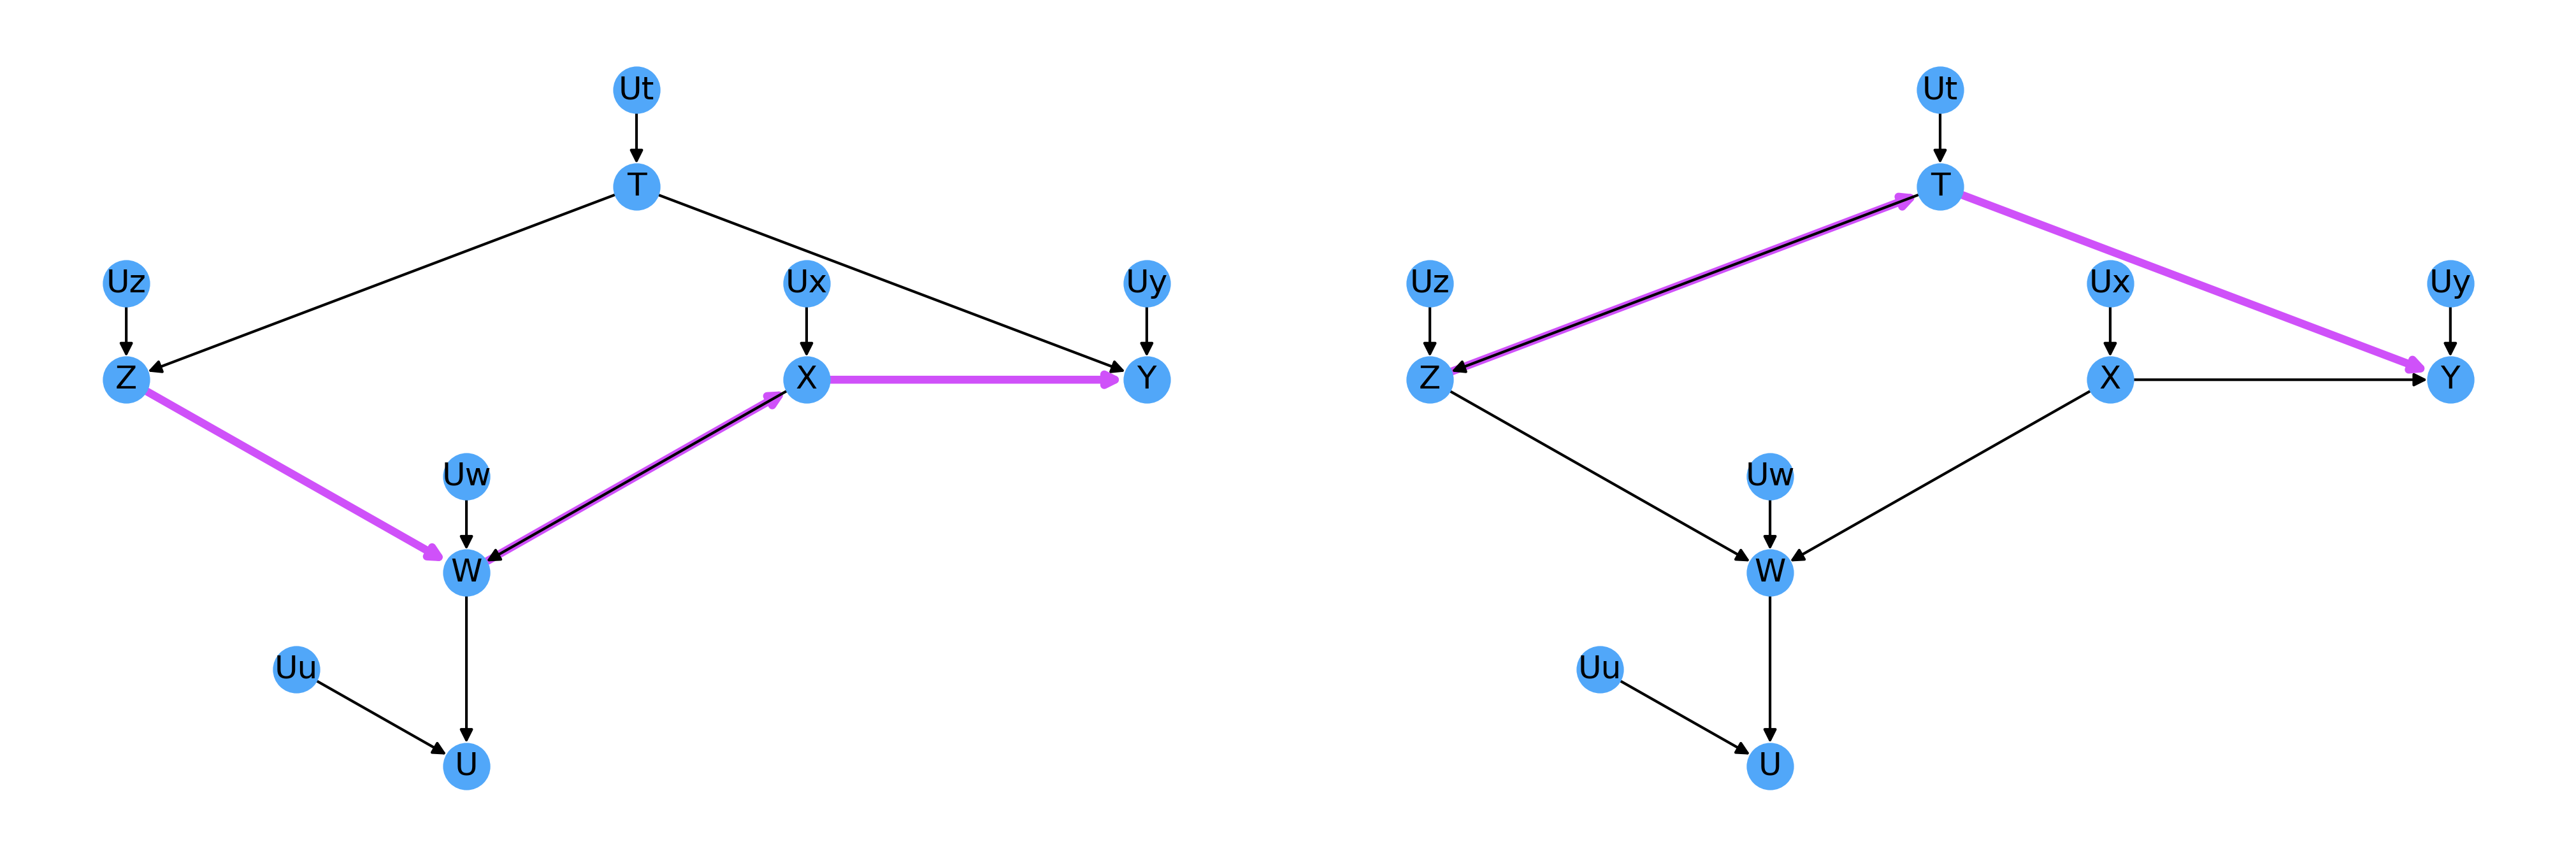

In [25]:
fig, ax_lst = plt.subplots(1, 2, figsize=(14, 5))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(list(G.all_paths('Z', 'Y'))[::-1]):
    G.plot_path(path, ax=ax_lst[i])

fig.tight_layout()

### Study question 2.4.1

In [26]:
G = CausalModel()
G.add_causation('Z1', 'Z3')
G.add_causation('Z1', 'X')
G.add_causation('Z2', 'Z3')
G.add_causation('Z2', 'Y')
G.add_causation('Z3', 'X')
G.add_causation('Z3', 'Y')
G.add_causation('X', 'W')
G.add_causation('W', 'Y')

G.pos = {'Z3':(0, 0), 'Z1':(-1, 1), 'Z2':(1, 1), 'X':(-1, -1), 'W':(0, -1), 'Y':(1, -1)}

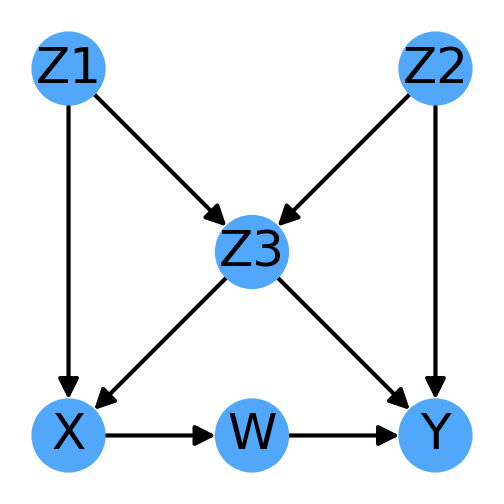

In [27]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [28]:
G.save_model('dags/Primer.Fig.2.9.dot')

We have 5 total paths connecting X and Y

In [29]:
G.all_paths('X', 'Y')

{('X', 'W', 'Y'),
 ('X', 'Z1', 'Z3', 'Y'),
 ('X', 'Z1', 'Z3', 'Z2', 'Y'),
 ('X', 'Z3', 'Y'),
 ('X', 'Z3', 'Z2', 'Y')}

That we can visualize side by side

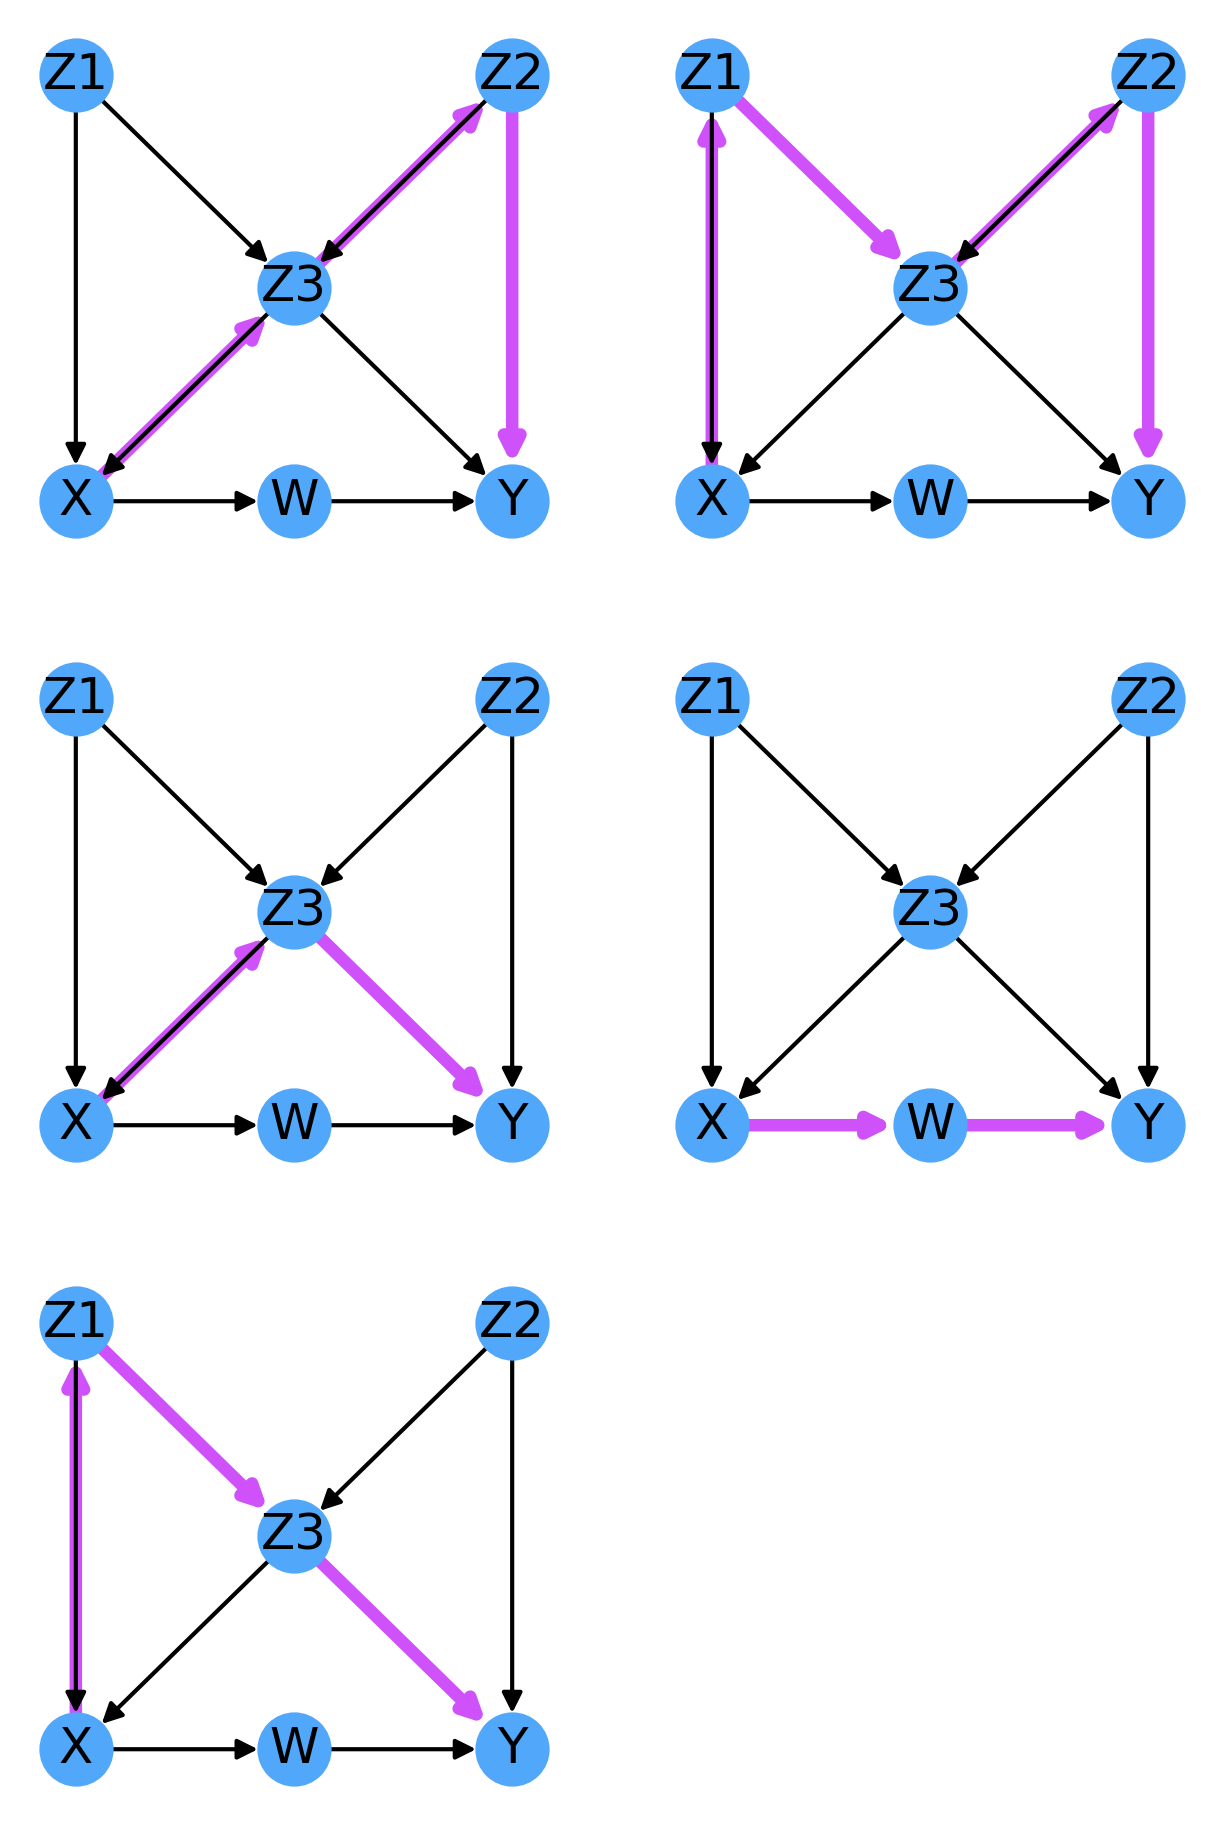

In [30]:
fig, ax_lst = plt.subplots(3, 2, figsize=(4.6, 6.6))
ax_lst = np.array(ax_lst).flatten()

for i, path in enumerate(G.all_paths('X', 'Y')):
    G.plot_path(path, ax=ax_lst[i])

ax_lst[-1].axis('off')
fig.tight_layout()

### Simulate the model

To verify our calculations we simulate the model using Gaussian distributed random numbers

In [31]:
N = 100000
df = pd.DataFrame({'Z1': np.random.normal(0, 1, N), 'Z2': np.random.normal(0, 1, N),})
df['Z3'] = df['Z1'] + df['Z2'] + np.random.normal(0, .1, N)
df['X'] = df['Z1'] + df['Z3'] + np.random.normal(0, .1, N)
df['W'] = df['X'] + np.random.normal(0, .1, N)
df['Y'] = df['W'] + + df['Z2'] + np.random.normal(0, .1, N)

In [32]:
df

,Z1,Z2,Z3,X,W,Y
0,-0.387377,-0.109948,-0.527837,-0.995259,-0.921754,-0.927942
1,-0.934852,-0.317952,-1.418703,-2.269803,-2.261546,-2.494821
2,0.182399,0.071590,0.278936,0.522428,0.509440,0.562283
3,1.257966,-1.807818,-0.366756,0.811625,0.732330,-1.044362
4,-1.456000,-1.572275,-3.127999,-4.523492,-4.745579,-6.375724
...,...,...,...,...,...,...
99995,-2.692478,-0.374073,-2.997116,-5.505274,-5.480375,-5.858789
99996,0.021126,-1.911499,-1.903887,-1.813362,-1.859691,-3.758737
99997,0.988823,-0.169244,0.786502,2.004139,1.828811,1.728937
99998,-2.219030,0.908438,-1.336919,-3.563230,-3.406738,-2.472206


And thest the conditional independence of X and Y

In [33]:
formula = 'X ~ 1 + Y + W + Z1 + Z3'

In [34]:
results = smf.ols(formula, df).fit()

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.505e+07
Date:                Sun, 13 Sep 2020   Prob (F-statistic):               0.00
Time:                        12:13:43   Log-Likelihood:             1.2307e+05
No. Observations:              100000   AIC:                        -2.461e+05
Df Residuals:                   99995   BIC:                        -2.461e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.000     -0.967      0.334      -0.001       0.000
Y              0.0005      0.002      0.298      0.766      -0.003       0.004
W              0.4990      0.002    223.453      0.000       0.495       0.503
Z1             0.5009      0.002    223.276      0.000       0.496       0.505
Z3             0.5005      0.002    223.108      0.000       0.496       0.505
==============================================================================
Omnibus:                        6.391   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.402
Skew:                           0.019   Prob(JB):                       0.0407
Kurtosis:                       2.989   Cond. No.                         59.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>